# TWSnet version 3 - Residual Autoencoder


In [491]:
import time
import numpy as np
from keras import models
from keras import layers
from keras import backend as K
from PIL import Image
from keras import optimizers
from keras.callbacks import TensorBoard
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline
import json
from glob import glob
import os
import src.residual_segnet_model as segnet
import src.segtools as segtools
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [233]:
#get the data
in_dirc = '/contents/images/train'
x_, y_ = segtools.get_xy_data(in_dirc, 1)
n_classes = len(np.unique(y_))
y_ = segtools.pre_process_y(y_[0], n_classes)
input_shape = x_.shape[1:]
output_shape = y_.shape
class_weights = [19.10052513, 0.51344048] #pre-calculated for the full dataset.
print(input_shape, output_shape)

(256, 256, 3) (65536, 2)


In [149]:
y = y_[0,:,:,:]
y_oneband = y[:,:,0]
y_out = np.zeros((y.shape[0], y.shape[1], n_classes))
for i in range(n_classes):
    y_out[:,:,i][y_oneband==i] = 1
out = y_out.reshape((y_out.shape[0]*y_out.shape[1], n_classes))


IndexError: too many indices for array

In [154]:
np.shape(y_)

(65536, 2)

In [235]:
K.clear_session()
initial_filter = 32
depth = 4
model = segnet.residual_segnet(input_shape, output_shape, \
                               n_classes, initial_filter, depth)
tensorboard = TensorBoard(log_dir='/contents/logs/', histogram_freq=0, write_graph=True, write_images=False)
opt = optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['categorical_accuracy'])
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 256, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 256, 256, 32) 128         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_1 (Activation)       (None, 256, 256, 32) 0           batch_normalization_1[0][0]      
__________________________________________________________________________________________________
dropout_1 

In [236]:
def data_size(in_dirc):
    return(len(glob('%s/a/*png'%in_dirc)))

sample_size = data_size(in_dirc)

In [237]:
nb_epoch = 1
batch_size = 6 
steps_per_epoch = sample_size // batch_size
model_out = []
for epoch in range(50):
#x_train, y_train = batch_gen(in_dirc, batch_size, gen_data=True)
#class_weights = segtools.get_weights(y_train)
    model_o = model.fit_generator(segtools.data_generator(in_dirc, batch_size=batch_size,\
                                                        augment_img=True),\
                                steps_per_epoch=steps_per_epoch, nb_epoch=nb_epoch,\
                                class_weight=class_weights, callbacks=[tensorboard])
    model_out.append(model_o.history)
#model.train_on_batch(x_train, y_train,\
#           class_weight=class_weights)
# print(model.evaluate(x_train, y_train))
          #verbose=True, callbacks=[tensorboard])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: The semantics of the Keras 2 argument `steps_per_epoch` is not the same as the Keras 1 argument `samples_per_epoch`. `steps_per_epoch` is the number of batches to draw from the generator at each epoch. Basically steps_per_epoch = samples_per_epoch/batch_size. Similarly `nb_val_samples`->`validation_steps` and `val_samples`->`steps` arguments have changed. Update your method calls accordingly.
  
/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:8: UserWarning: Update your `fit_generator` call to the Keras 2 API: `fit_generator(<generator..., steps_per_epoch=1207, class_weight=[19.100525..., epochs=1, callbacks=[<keras.ca...)`
  


Epoch 1/1
1207/1207 [==============================] - 904s 749ms/step - loss: 0.1010 - categorical_accuracy: 0.9732
Epoch 1/1
1207/1207 [==============================] - 904s 749ms/step - loss: 0.0621 - categorical_accuracy: 0.9764
Epoch 1/1
1207/1207 [==============================] - 904s 749ms/step - loss: 0.0572 - categorical_accuracy: 0.9780
Epoch 1/1
1207/1207 [==============================] - 912s 756ms/step - loss: 0.0554 - categorical_accuracy: 0.9786
Epoch 1/1
1207/1207 [==============================] - 913s 756ms/step - loss: 0.0539 - categorical_accuracy: 0.9791
Epoch 1/1
1207/1207 [==============================] - 912s 756ms/step - loss: 0.0531 - categorical_accuracy: 0.9794
Epoch 1/1
1207/1207 [==============================] - 912s 755ms/step - loss: 0.0522 - categorical_accuracy: 0.9797
Epoch 1/1
1207/1207 [==============================] - 912s 755ms/step - loss: 0.0518 - categorical_accuracy: 0.9799
Epoch 1/1
1207/1207 [==============================] - 912s 755m

In [242]:
t = time.strftime('%Y%m%d%H%M', time.gmtime())
os.makedirs('./fit_models/%s'%t)
model.save_weights('./fit_models/%s/seg_net.h5'%t)
# serialize model to JSON

with open('./fit_models/%s/seg_net.json'%t, 'w') as outfile:
    outfile.write(json.dumps(json.loads(model.to_json()), indent=2))
with open('/contents/fit_models/model_acc.json', 'w') as fout:
    json.dump(model_out, fout)

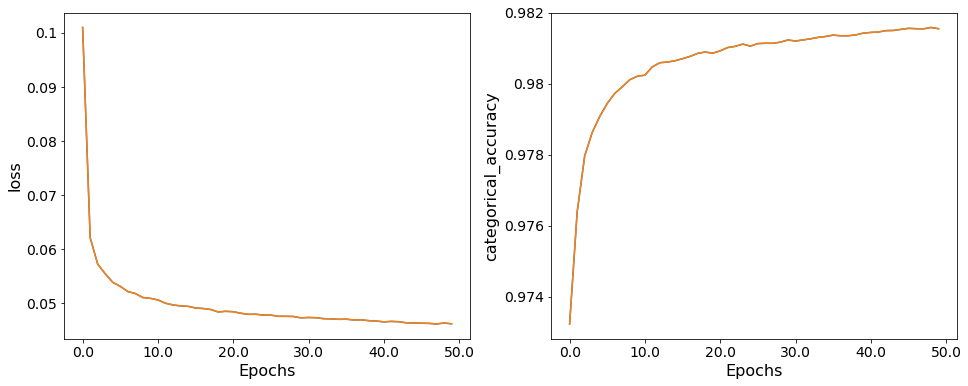

In [446]:
'''
b = {'loss':[], 'categorical_accuracy':[]} #emtpy dict
for d in model_out:
    for k,v in d.items():
        #print(k,v)
        b[k].append(v[0])
'''
# the above as a one liner
b = {k:[d[k][0] for d in model_out] for d in model_out for k,v in d.items()} 

f, ax = plt.subplots(1,2,figsize=(16,6))
ax[0].plot(b['loss'])
ax[1].plot(b['categorical_accuracy'])
keys = list(b.keys())
for i in range(len(keys)):
    ax[i].plot(b[keys[i]])
    ax[i].set_xlabel('Epochs', fontsize=16)
    ax[i].set_ylabel(keys[i], fontsize=16)
    ax[i].set_xticklabels(ax[i].get_xticks(),fontsize=14)
    ax[i].set_yticklabels(ax[i].get_yticks(),fontsize=14)

In [410]:
# get validation data to check things out
val_batch = 200
val_generator = segtools.data_generator('/contents/images/val', batch_size=200)
x_val, y_val = next(val_generator)


In [411]:
pr = model.predict(x_val)
predictions = []
for i in range(len(pr)):
    predictions.append(pr[i].reshape((256,256,n_classes)))
predictions = np.array(predictions)
norm_pred = segtools.normalize_stack(predictions[:,:,:,0])

0.026880961466005514


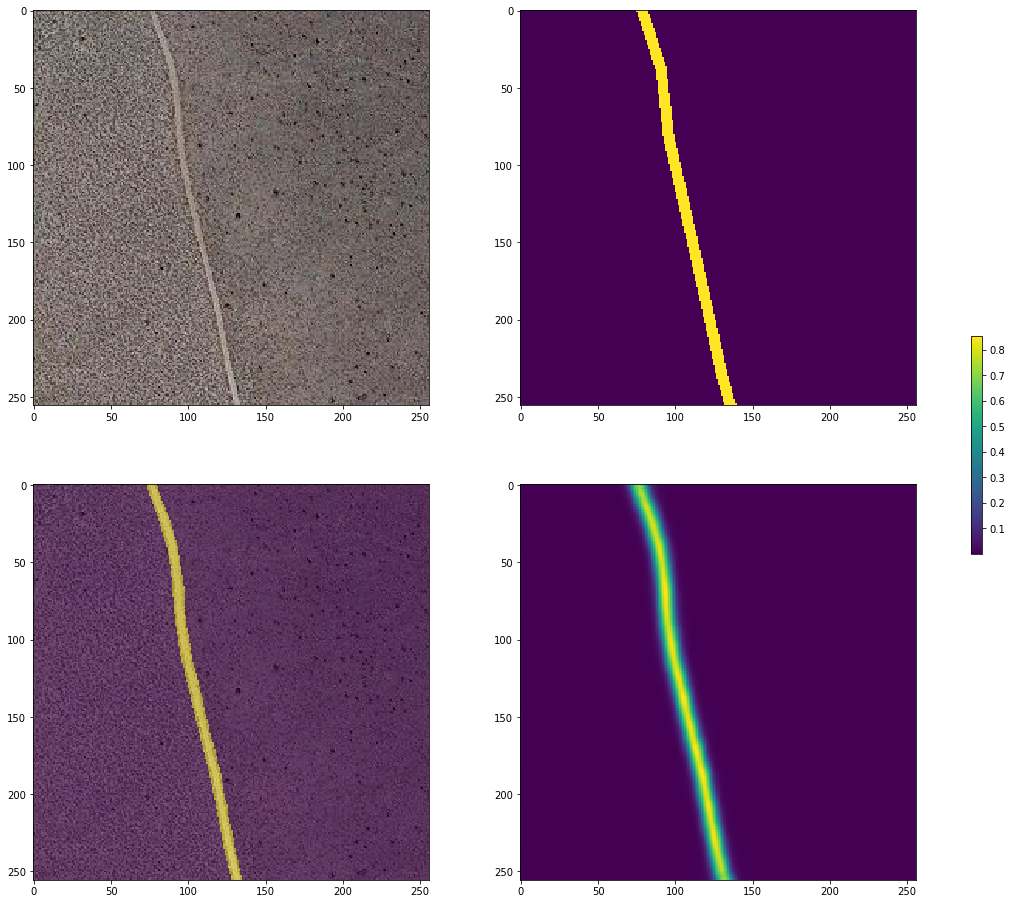

In [509]:
thr=class_weights[1]/class_weights[0]
print(thr)
thr=0.1
f, ax = plt.subplots(2,2, figsize=(20, 16))
sample=np.random.randint(0, len(x_val))
sample=99
x_ = x_val[sample].astype('float32')
y_ = y_val[sample].reshape(256,256,n_classes)[:,:,0]
ax[0,0].imshow(x_)
ax[0,1].imshow(y_)
ax[1,0].imshow(x_)
#mask = np.zeros((256,256))
#mask[norm_pred[sample]>=thr] = 1
#ax[1,0].imshow(mask,alpha=0.5)
mask = np.argmax(pr[sample].reshape(256,256,n_classes), axis=2)
ax[1,0].imshow(~mask,alpha=0.5)

im = ax[1,1].imshow(norm_pred[sample])
f.colorbar(im, ax=ax.ravel().tolist(), shrink=0.25)

0.0196011378297 0.686445291236 0.0381139489194


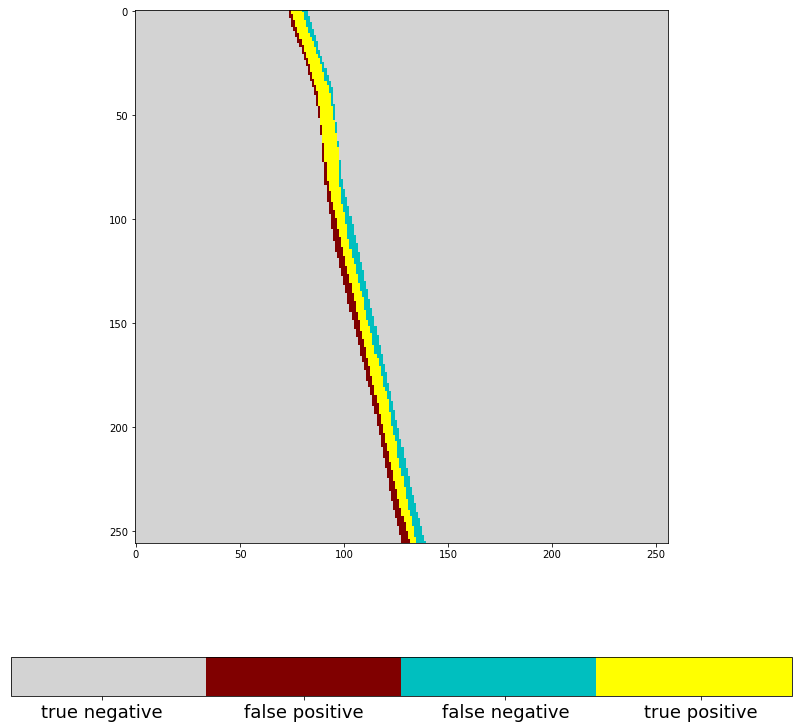

In [600]:
N = 4
model_acc = 2*y_val[sample].reshape(256,256,n_classes)[:,:,0] - \
    np.argmax(pr[sample].reshape(256,256,n_classes), axis=2)

c, counts = np.unique(model_acc, return_counts=True)
# -1 : TN
# 0: FP 
# 1 : FN
# 2 : TP
precision = counts[3]/(counts[3]+counts[0])
recall = counts[3]/(counts[3]+counts[1])
f1 = 2*((precision*recall)/(precision+recall))
print(precision, recall, f1)
f, ax = plt.subplots(1,1,figsize=(14,14))

cmap = mpl.colors.ListedColormap(['lightgrey','maroon','c', 'yellow'])
im=ax.imshow(model_acc, cmap=cmap)
bounds = [-0.65, 0.125, 0.9, 1.65]
labels = ['true negative', 'false positive', 'false negative', 'true positive']
cb = f.colorbar(im, orientation='horizontal')
cb.set_ticks(bounds)
cb.set_ticklabels(labels)
cb.ax.tick_params(labelsize=18)

In [508]:
sample

99

In [471]:
sample_list=[85, 99]

85

In [159]:
# attempt to write a precision and recall estimate
# also consider f1 score.

tr = []
tpr = []
a = []
cc = []
classified = np.zeros((pr.shape[0], pr.shape[1],1))
thr = 0.15
classified[pr[:,:,0]>=thr]=1
r = y_val[:,:,0].astype('bool')
p_r = classified[:,:,0].astype('bool')
for i in range(len(pr)):
    tr.append(np.sum(r[i]))
    tpr.append(np.sum(p_r[i]))
    a.append(np.sum(np.logical_and(r[i], p_r[i])))
tr = np.array(tr)
tpr = np.array(tpr)
a = np.array(a)
completeness = np.nanmean(np.divide(a,tr))
correctness = np.nanmean(np.divide(a,tpr))
cc.append([completeness, correctness])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:18: RuntimeWarning: invalid value encountered in true_divide


IndexError: invalid index to scalar variable.

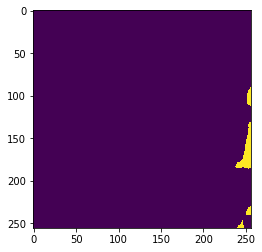

In [160]:
sample = 20
plt.imshow(p_r[sample].reshape(256,256))
print(completeness[sample])

In [161]:
np.nanmean(completeness)

0.32842770780598957

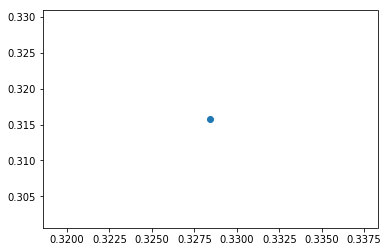

In [162]:
plt.scatter(completeness, correctness)

In [163]:
plt.imshow(np.reshape(classes[0], (256,256)))

ValueError: cannot reshape array of size 1 into shape (256,256)

In [164]:
# construct a confusion matrix using various masks...
t_min = 0
t_max = 0.2
n_thr = 2
c = pr[:,:,0]
c.reshape((c.shape[0]*c.shape[1]))
def generate_threshold_masks(c, n_thr, t_min, t_max):
    input_shape = np.shape(c)
    masks = np.zeros((n_thr, np.shape(c))).astype('bool')
    thr = np.linspace(t_min, t_max, n_thr) 
    for i in range(len(t)):
        masks[i][c>=thr[i]] = True 
    return(masks)
masks = generate_threshold_masks(c, n_thr, t_min, t_max)

TypeError: 'tuple' object cannot be interpreted as an integer

In [144]:
target = y_val[:,:,0].astype('bool')
n_cells = np.shape(target)[0] * np.shape(target)[1]

#overall accuracy.
sensitivity = np.zeros(len(masks)) 
specificity = np.zeros(len(masks)) 
for i in range(len(masks)):
    print(np.sum((target & masks[i]))/n_cells)
    print(np.sum((~target & ~masks[i]))/n_cells)

NameError: name 'masks' is not defined

# Try predicting on the entire Tonopah dataset

## See 'predictions.ipynb'